In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pyquil.api as api
from pyquil.gates import *
from pyquil.quil import Program

In [2]:
def qubit_strings(n):
    qubit_strings = []
    for q in itertools.product(['0', '1'], repeat=n):
        qubit_strings.append(''.join(q))
    return qubit_strings

In [3]:
def black_box_map(n, q_find):
    """
    Black-box map, f(x), on n qubits such that f(q_find) = 1, and otherwise = 0
    """
    qubs = qubit_strings(n)
    d_blackbox = {q: 1 if q == q_find else 0 for q in qubs}
    return d_blackbox

In [4]:
def qubit_ket(qub_string):
    """
    Form a basis ket out of n-bit string specified by the input 'qub_string', e.g.
    '001' -> |001>
    """
    e0 = np.array([[1], [0]])
    e1 = np.array([[0], [1]])
    d_qubstring = {'0': e0, '1': e1}

    # initialize ket
    ket = d_qubstring[qub_string[0]]
    for i in range(1, len(qub_string)):
        ket = np.kron(ket, d_qubstring[qub_string[i]])
    
    return ket

In [5]:
def projection_op(qub_string):
    """
    Creates a projection operator out of the basis element specified by 'qub_string', e.g.
    '101' -> |101> <101|
    """
    ket = qubit_ket(qub_string)
    bra = np.transpose(ket)  # all entries real, so no complex conjugation necessary
    proj = np.kron(ket, bra)
    return proj

In [6]:
def black_box(n, q_find):
    """
    Unitary representation of the black-box operator on (n+1)-qubits
    """
    d_bb = black_box_map(n, q_find)
    # initialize unitary matrix
    N = 2**(n+1)
    unitary_rep = np.zeros(shape=(N, N))
    # populate unitary matrix
    for k, v in d_bb.items():
        unitary_rep += np.kron(projection_op(k), np.eye(2) + v*(-np.eye(2) + np.array([[0, 1], [1, 0]])))
    return unitary_rep

In [7]:
def U_grov(n):
    """
    The operator 2|psi><psi| - I , where |psi> = H^n |0>
    """
    qubs = qubit_strings(n)
    N = 2**n
    proj_psipsi = np.zeros(shape=(N, N))
    for s_ket in qubs:
        ket = qubit_ket(s_ket)
        for s_bra in qubs:
            bra = np.transpose(qubit_ket(s_bra))  # no complex conjugation required
            proj_psipsi += np.kron(ket, bra)
    # add normalization factor
    proj_psipsi *= 1/N

    return 2*proj_psipsi - np.eye(N)

### Grover's Search Algorithm

In [8]:
# Specify an item to find
findme = '1011'

The most probable outcome is: |1011>


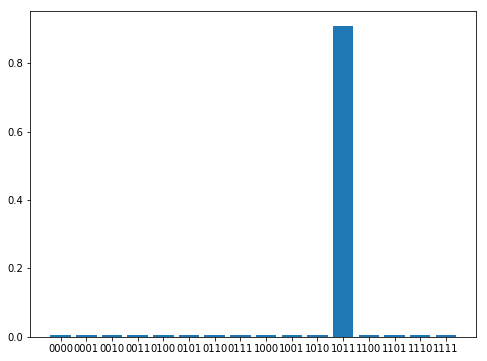

In [9]:
# number of qubits (excluding the ancilla)
n = len(findme)
# number of iterations
num_iters = max(1, int(np.sqrt(2**(n-2))))

p = Program()
# define blackbox operator (see above)
p.defgate("U_bb", black_box(n, findme))
# define the U_grov (see above)
p.defgate("U_grov", U_grov(n))
# Apply equal superposition state
for q in range(1, n+1):
    p.inst(H(q))
# Make 0th qubit an eigenstate of the black-box operator
p.inst(H(0))
p.inst(Z(0))
    
# Grover iterations
for _ in range(num_iters):
    # apply oracle
    p.inst(("U_bb",) + tuple(range(n+1)[::-1]))
    # apply H . U_perp . H
    p.inst(("U_grov",) + tuple(range(1, n+1)[::-1]))
    
# measure and discard ancilla
p.measure(0, [0])
    
# run program, and investigate wavefunction
qvm = api.QVMConnection()
wavefunc = qvm.wavefunction(p)
outcome_probs = wavefunc.get_outcome_probs()
print ("The most probable outcome is: |%s>" % (max(outcome_probs, key=outcome_probs.get)[:-1]))

# histogram of outcome probs
plt.figure(figsize=(8, 6))
plt.bar([i[:-1] for i in outcome_probs.keys()], outcome_probs.values())
plt.show()